In [2]:
from  QuantLib import *
import numpy as np
from math import *
from pylab import *

def A(t,T):
    forward = crvToday.forwardRate(t, t,Continuous, NoFrequency).rate()
    value = B(t,T)*forward - 0.25*sigma*B(t,T)*sigma*B(t,T)*B(0.0,2.0*t);
    return exp(value)*crvToday.discount(T)/crvToday.discount(t);

def B(t,T):
    return (1.0-exp(-a*(T-t)))/a;

def gamma(t):
        forwardRate =crvToday.forwardRate(t, t, Continuous, NoFrequency).rate()
        temp = sigma*(1.0 - exp(-a*t))/a
        return (forwardRate + 0.5*temp*temp)

def gamma_v(t):
    res=np.zeros(len(t))
    for i in xrange(len(t)):
        res[i]=gamma(t[i])
    return res

In [3]:
Nsim=100
a=0.1
sigma=0.02

todaysDate=Date(30,12,2013);
Settings.instance().evaluationDate=todaysDate;
crvToday=FlatForward(todaysDate,0.02,Actual360())

r0=forwardRate =crvToday.forwardRate(0,0, Continuous, NoFrequency).rate()
months=range(1,12*5,1)
sPeriods=[str(month)+"m" for month in months]
Dates=[todaysDate]+[todaysDate+Period(s) for s in sPeriods]
T=[0]+[Actual360().yearFraction(todaysDate,Dates[i]) for i in xrange(1,len(Dates))]
T=np.array(T)
rmean=r0*np.exp(-a*T)+ gamma_v(T) -gamma(0)*np.exp(-a*T)

np.random.seed(1)
stdnorm = np.random.standard_normal(size=(Nsim,len(T)-1))

rmat=np.zeros(shape=(Nsim,len(T)))
rmat[:,0]=r0

for iSim in xrange(Nsim):
    for iT in xrange(1,len(T)):
        mean=rmat[iSim,iT-1]*exp(-a*(T[iT]-T[iT-1]))+gamma(T[iT])-gamma(T[iT-1])*exp(-a*(T[iT]-T[iT-1]))
        var=0.5*sigma*sigma/a*(1-exp(-2*a*(T[iT]-T[iT-1])))
        rmat[iSim,iT]=mean+stdnorm[iSim,iT-1]*sqrt(var)

startDate=Date(30,12,2013);

crvMat= [ [ 0 for i in xrange(len(T)) ] for iSim in range(Nsim) ]
npvMat= [ [ 0 for i in xrange(len(T)) ] for iSim in range(Nsim) ]

In [4]:
for row in crvMat:
    row[0]=crvToday

for iT in xrange(1,len(T)):
    for iSim in xrange(Nsim):
        crvDate=Dates[iT];
        crvDates=[crvDate]+[crvDate+Period(k,Years) for k in xrange(1,21)]
        crvDiscounts=[1.0]+[A(T[iT],T[iT]+k)*exp(-B(T[iT],T[iT]+k)*rmat[iSim,iT]) for k in xrange(1,21)]
        crvMat[iSim][iT]=DiscountCurve(crvDates,crvDiscounts,Actual360(),TARGET())

#indexes definitions
forecastTermStructure = RelinkableYieldTermStructureHandle()
index = Euribor(Period("6m"),forecastTermStructure)

#swap 1 definition
maturity = Date(30,12,2018);
fixedSchedule = Schedule(startDate, maturity,Period("6m"), TARGET(),ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
floatingSchedule = Schedule(startDate, maturity,Period("6m"),TARGET() ,ModifiedFollowing,ModifiedFollowing,DateGeneration.Forward, False)
swap1 = VanillaSwap(VanillaSwap.Receiver, 1000000,fixedSchedule,0.05 , Actual360(),floatingSchedule, index, 0,Actual360())  #0.01215


In [11]:
index

<QuantLib.QuantLib.Euribor; proxy of <Swig Object of type 'EuriborPtr *' at 0x107366bd0> >

In [5]:
for iT in xrange(len(T)):
    Settings.instance().evaluationDate=Dates[iT]
    allDates= list(floatingSchedule)
    fixingdates=[index.fixingDate(floatingSchedule[iDate]) for iDate in xrange(len(allDates)) if index.fixingDate(floatingSchedule[iDate])<=Dates[iT]]
    if fixingdates:
        for date in fixingdates[:-1]:
            try:index.addFixing(date,0.0)
            except:pass
        try:index.addFixing(fixingdates[-1],rmean[iT])
        except:pass
    discountTermStructure = RelinkableYieldTermStructureHandle()
    swapEngine = DiscountingSwapEngine(discountTermStructure)
    swap1.setPricingEngine(swapEngine)

    for iSim in xrange(Nsim):
        crv=crvMat[iSim][iT]
        discountTermStructure.linkTo(crv)
        forecastTermStructure.linkTo(crv)
        npvMat[iSim][iT]=swap1.NPV()

npvMat=np.array(npvMat)
npvMat[npvMat<0]=0
EE=np.mean(npvMat,axis=0)

S=0.05 #constant CDS spread
R=0.4  #Recovery rate 40%

sum=0


CVA= 17008.5902689

EE
[[ 143606.52236152  110892.25913033  123290.20415129 ...,   13967.58057333
    13977.69516598   14005.16151835]
 [ 143606.52236152  126227.03001656  141763.93414938 ...,   13899.14723321
    13944.45211361   14001.20809908]
 [ 143606.52236152  121295.88270064  113094.03325023 ...,   13806.22098036
    13884.49671652   13951.8993805 ]
 ..., 
 [ 143606.52236152  122839.24885826  100364.02025741 ...,   13945.0936529
    13977.09778729   14012.67541012]
 [ 143606.52236152  132998.08151752  166252.5282214  ...,   14097.25299989
    14095.04320873   14067.92423857]
 [ 143606.52236152  177737.59151528  194720.39115905 ...,   14071.24723422
    14064.61259999   14040.44191233]]


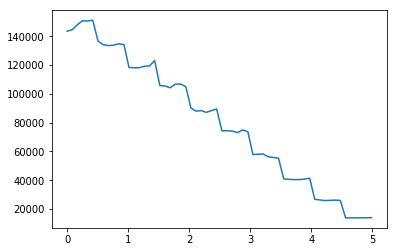

In [6]:
#calculate CVA
for i in xrange(len(T)-1):
    sum=sum+0.5*(EE[i]*crvToday.discount(T[i])+EE[i+1]*crvToday.discount(T[i+1]))*(exp(-S*T[i]/(1.0-R))-exp(-S*T[i+1]/(1.0-R)))
CVA=(1.0-R)*sum

print "\nCVA=",CVA

plot(T,EE)
print "\nEE\n",npvMat
show()